In [1]:
%cd ..

/home/nikita/edu/ai-masters/nla1/project


In [2]:
import os
import numpy as np
import torch
from torch import nn
from matplotlib import pyplot as plt

from torchvision.models import resnet152, ResNet152_Weights

import datasets

from conv_cp import FGSM

In [3]:
transform = ResNet152_Weights.IMAGENET1K_V2.transforms()
model = resnet152(weights=ResNet152_Weights.IMAGENET1K_V2)

In [4]:
# You have to set huggingface read token environmental variable
# and request access on https://huggingface.co/datasets/ILSVRC/imagenet-1k
# to run this code
assert os.environ["HUGGING_FACE_HUB_TOKEN"] 
dataset = datasets.load_dataset(
    "imagenet-1k", split="validation", trust_remote_code=True, streaming=True
)

In [5]:
# This is how to get samples from dataset with streaming=True
dataset_iter = iter(dataset)
samples = [next(dataset_iter) for _ in range(32)]
images = [sample["image"] for sample in samples]
labels = [sample["label"] for sample in samples]

In [6]:
model.eval()
with torch.no_grad():
    preds = torch.softmax(model(transform(images[0]).unsqueeze(0)), dim=-1)[0]
preds.topk(5)

torch.return_types.topk(
values=tensor([8.5608e-01, 3.4541e-04, 3.3547e-04, 3.3334e-04, 3.2873e-04]),
indices=tensor([ 91,  90,  93, 497,  63]))

In [7]:
class Model(nn.Module):
    def __init__(self, model: nn.Module, transform: nn.Module):
        super().__init__()
        self.model = model
        self.transform = transform

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.model(self.transform(x))
    
model = Model(model, transform)

In [8]:
img = torch.tensor(np.array(images[0])).permute(2, 0, 1).unsqueeze(0) / 255

result = FGSM(
    model,
    img,
    epsilon=0.01,
)

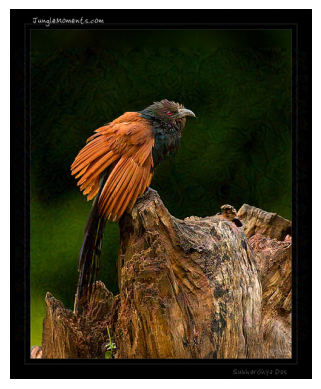

torch.return_types.topk(
values=tensor([0.1291, 0.0164, 0.0120, 0.0107, 0.0092]),
indices=tensor([514, 364,   8,  23, 377]))


In [9]:
plt.imshow(result.adversarial_images[0].permute(1, 2, 0).numpy())
plt.axis("off")
plt.show()
with torch.no_grad():
    print(model.forward(result.adversarial_images).softmax(dim=-1)[0].topk(5))